In [102]:
import numpy as np

from scipy.io import wavfile
from scipy.signal import get_window
import scipy.fftpack as fft

import matplotlib.pyplot as plt

In [32]:
sample_rate, audio = wavfile.read("./sound_data/artifact__201012172012.wav")

In [33]:
print("Default rate {}Hz".format(sample_rate))
print("Audio duration {}s".format(audio.shape[0] / sample_rate))
print("Audio shape {}".format(audio.shape))

Default rate 44100Hz
Audio duration 9.0s
Audio shape (396900,)


Text(0, 0.5, 'Amplitude')

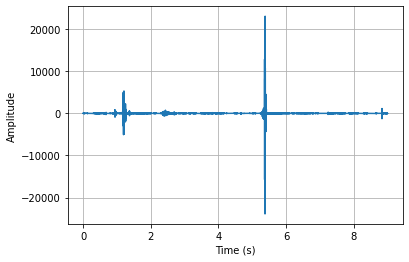

In [34]:
## plot audio
plt.figure()
plt.plot(np.linspace(0, audio.shape[0] / sample_rate, num=audio.shape[0]), audio)
plt.grid(True)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")

Text(0, 0.5, 'Amplitude')

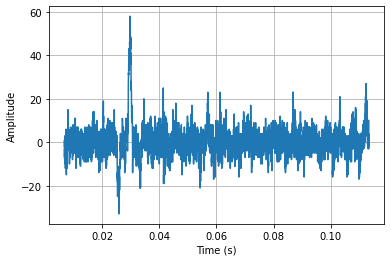

In [35]:
## plot more precisely
audio_sample = audio[300:5000]
linspace = np.linspace(0, audio.shape[0] / sample_rate, num=audio.shape[0])[300:5000]
plt.figure()
plt.plot(linspace, audio_sample)
plt.grid(True)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")

## Data Normalization

In [36]:
## normalization of the data
def normalize_audio(audio):
    '''
    Normalize audio file according absolute maximum
    '''
    return audio / np.max(np.abs(audio))

In [37]:
audio = normalize_audio(audio)

Text(0, 0.5, 'Amplitude')

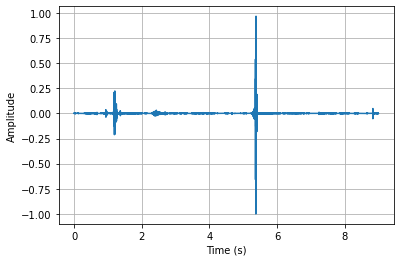

In [38]:
## plot normalized data
plt.figure()
plt.plot(np.linspace(0, audio.shape[0] / sample_rate, num=audio.shape[0]), audio)
plt.grid(True)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")

Text(0, 0.5, 'Amplitude')

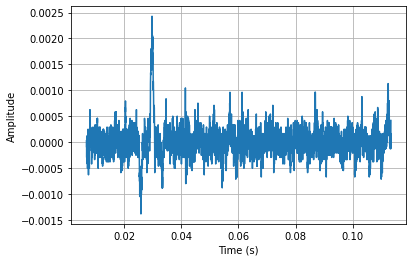

In [39]:
## plot more precisely normalized audio
audio_sample = audio[300:5000]
linspace = np.linspace(0, audio.shape[0] / sample_rate, num=audio.shape[0])[300:5000]
plt.figure()
plt.plot(linspace, audio_sample)
plt.grid(True)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")

## Audio Framing

Audio -> non stationary process -> FFT produce distortions

So we assume that audio is stationary on a short period of time

-> So we divide the audio into short frames (overlapping frames)

In [77]:
## each audio frame: same size as FFT
def frame_audio(audio, FFT_size=2048, hop_size=15, sample_rate=44100):
    '''
    audio: audio vector
    FFT_size: size of the FFT and of the frames
    hop_size: overlap length
    sample_rate: rate of the sample
    '''
    audio = np.pad(audio, int(FFT_size / 2), mode='reflect') # avoid losing information
    frame_len = int(np.round(sample_rate * hop_size / 1000))
    frame_num = int((audio.shape[0] - FFT_size) / frame_len) + 1
    
    frames = np.zeros((frame_num, FFT_size))
    
    for i in range(frame_num):
        frames[i] = audio[i * frame_len:i * frame_len + FFT_size]
    return frames

In [78]:
frames = frame_audio(audio)
print(frames.shape)

(600, 2048)


In [79]:
print(frames[0])

[ 0.00000000e+00 -8.37275506e-05 -4.18637753e-05 ...  8.37275506e-05
 -4.18637753e-05 -8.37275506e-05]


## Convert into frequency domain

Using Hann Window

From time domain to frequency domain

FFT assumes that the signal is periodic and continuous

Windowing reduces the amplitude of the discontinuities at the boundaries of each finite sequence acquired by the digitizer

Text(0, 0.5, 'Amplitude')

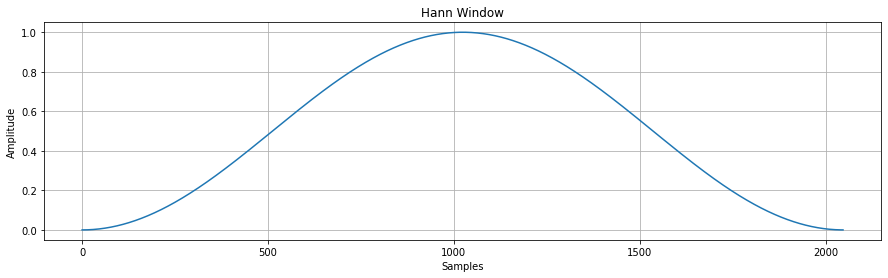

In [84]:
## Hann Window
FFT_size = 2048
window = get_window("hann", FFT_size, fftbins=True)
plt.figure(figsize=(15,4))
plt.plot(window)
plt.grid(True)
plt.title("Hann Window")
plt.xlabel("Samples")
plt.ylabel("Amplitude")

In [88]:
audio_win = frames * window

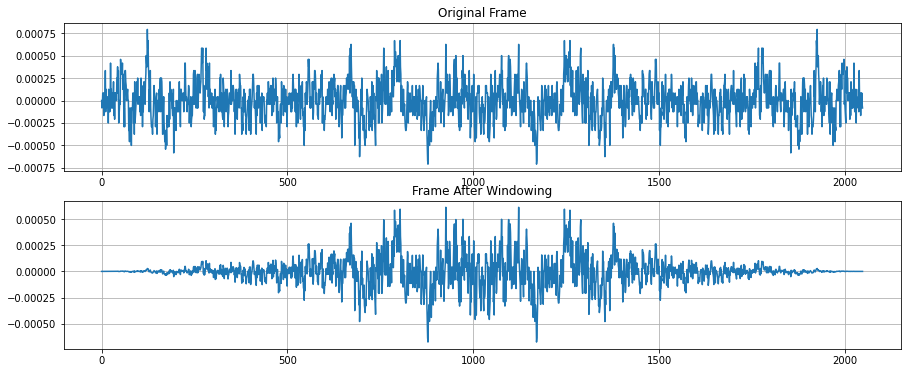

In [91]:
ind = 0
plt.figure(figsize=(15,6))
plt.subplot(2, 1, 1)
plt.plot(frames[ind])
plt.title('Original Frame')
plt.grid(True)
plt.subplot(2, 1, 2)
plt.plot(audio_win[ind])
plt.title('Frame After Windowing')
plt.grid(True)

In [97]:
## FFT
## Take only the positive part of the spectrum
audio_winT = np.transpose(audio_win)
audio_winT.shape

(2048, 600)

In [117]:
audio_fft = np.empty((int(1+FFT_size//2), audio_winT.shape[1]))

for i in range(audio_win.shape[0]):
    audio_fft[:, i] = fft.fft(audio_winT[:, i], axis=0)[:audio_fft.shape[0]]
    
audio_fft = np.transpose(audio_fft)

<ipython-input-117-096dac63cd5f>:4: ComplexWarning: Casting complex values to real discards the imaginary part
  audio_fft[:, i] = fft.fft(audio_winT[:, i], axis=0)[:audio_fft.shape[0]]


In [119]:
audio_fft.shape

(600, 1025)

In [123]:
## compute the power of the signal
audio_power = np.square(audio_fft)

## Mel-spaced filterbank

Gives information about the power in each frequency band

The spacing between the filters which grows exponentially with frequency

In [195]:
freq_min = 0
freq_high = sample_rate / 2
mel_filter_num = 128

print("Minimum frequency: {0}".format(freq_min))
print("Maximum frequency: {0}".format(freq_high))

Minimum frequency: 0
Maximum frequency: 22050.0


In [196]:
## Compute filter points
## They determine the start and stop of the filters

def freq_to_mel(freq):
    return 2595.0 * np.log10(1.0 + freq / 700.0)

def mel_to_freq(mels):
    return 700.0 * (10.0**(mels / 2595.0) - 1.0)

def get_filter_points(fmin, fmax, mel_filter_num, FFT_size, sample_rate=44100):
    '''
    fmin: min frequency
    fmax: max frequency
    mel_filter_num: number of filter to get
    FFT_size: size of the fast fourier transform
    sample_rate: rate of the signal
    '''
    fmin_mel = freq_to_mel(fmin)
    fmax_mel = freq_to_mel(fmax)
    
    print("MEL min: {0}".format(fmin_mel))
    print("MEL max: {0}".format(fmax_mel))
    
    mels = np.linspace(fmin_mel, fmax_mel, num=mel_filter_num+2)
    freqs = mel_to_freq(mels)
    
    return np.floor((FFT_size + 1) / sample_rate * freqs).astype(int), freqs

In [197]:
filter_points, mel_freqs = get_filter_points(freq_min, freq_high, mel_filter_num, FFT_size, sample_rate=44100)
filter_points

MEL min: 0.0
MEL max: 3923.337321740179


array([   0,    0,    1,    2,    3,    4,    5,    6,    7,    8,   10,
         11,   12,   13,   14,   16,   17,   18,   20,   21,   23,   24,
         26,   27,   29,   31,   33,   34,   36,   38,   40,   42,   44,
         46,   48,   51,   53,   55,   58,   60,   63,   65,   68,   71,
         74,   77,   80,   83,   86,   89,   92,   96,   99,  103,  107,
        110,  114,  118,  123,  127,  131,  136,  140,  145,  150,  155,
        160,  165,  171,  176,  182,  188,  194,  200,  207,  213,  220,
        227,  234,  241,  249,  256,  264,  272,  281,  289,  298,  307,
        317,  326,  336,  346,  356,  367,  378,  389,  401,  413,  425,
        437,  450,  463,  477,  491,  505,  520,  535,  551,  567,  583,
        600,  617,  635,  653,  672,  691,  711,  732,  753,  774,  796,
        819,  842,  866,  891,  916,  942,  968,  996, 1024])

In [198]:
mel_freqs

array([0.00000000e+00, 1.91476507e+01, 3.88190622e+01, 5.90285613e+01,
       7.97908667e+01, 1.01121100e+02, 1.23034796e+02, 1.45547914e+02,
       1.68676851e+02, 1.92438453e+02, 2.16850024e+02, 2.41929344e+02,
       2.67694678e+02, 2.94164792e+02, 3.21358964e+02, 3.49296999e+02,
       3.77999245e+02, 4.07486607e+02, 4.37780559e+02, 4.68903166e+02,
       5.00877094e+02, 5.33725630e+02, 5.67472698e+02, 6.02142876e+02,
       6.37761415e+02, 6.74354255e+02, 7.11948048e+02, 7.50570174e+02,
       7.90248761e+02, 8.31012708e+02, 8.72891703e+02, 9.15916248e+02,
       9.60117676e+02, 1.00552818e+03, 1.05218084e+03, 1.10010962e+03,
       1.14934943e+03, 1.19993614e+03, 1.25190659e+03, 1.30529863e+03,
       1.36015114e+03, 1.41650407e+03, 1.47439847e+03, 1.53387650e+03,
       1.59498149e+03, 1.65775792e+03, 1.72225153e+03, 1.78850928e+03,
       1.85657943e+03, 1.92651156e+03, 1.99835660e+03, 2.07216687e+03,
       2.14799613e+03, 2.22589961e+03, 2.30593404e+03, 2.38815772e+03,
      

In [199]:
def get_filters(filter_points, FFT_size):
    filters = np.zeros((filter_points.shape[0] - 2, int(FFT_size / 2 + 1)))
    
    for i in range(filter_points.shape[0] - 2):
        filters[i, filter_points[i]:filter_points[i + 1]] = np.linspace(0, 1, filter_points[i + 1] - filter_points[i])
        filters[i, filter_points[i + 1]:filter_points[i + 2]] = np.linspace(1, 0, filter_points[i + 2] - filter_points[i + 1])
    return filters

In [200]:
filters = get_filters(filter_points, FFT_size)

In [201]:
filters.shape

(128, 1025)

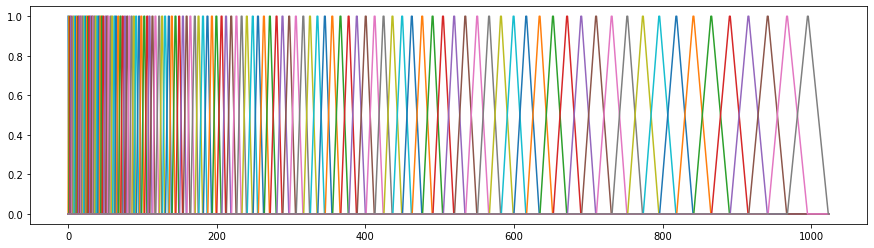

In [202]:
plt.figure(figsize=(15,4))
for n in range(filters.shape[0]):
    plt.plot(filters[n])

In [203]:
enorm = 2.0 / (mel_freqs[2:mel_filter_num+2] - mel_freqs[:mel_filter_num])

In [204]:
filters *= enorm[:, np.newaxis]

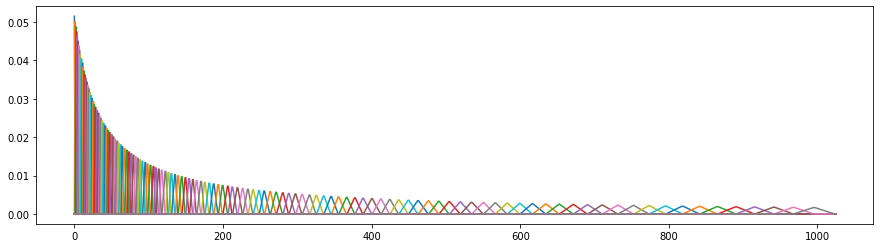

In [205]:
plt.figure(figsize=(15,4))
for i in range(filters.shape[0]):
    plt.plot(filters[i])

In [206]:
audio_filtered = np.dot(filters, np.transpose(audio_power))
audio_log = 10.0 * np.log10(audio_filtered)
audio_log.shape

(128, 600)

In [207]:
audio_log.shape

(128, 600)

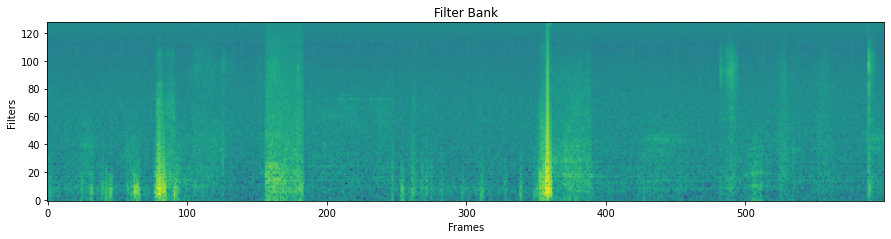

In [219]:
# display filters according to each frame
plt.figure(figsize=(15, 4))
plt.imshow(audio_log, origin='lower')
plt.xlabel('Frames')
plt.ylabel('Filters')
plt.title('Filter Bank')
plt.show()

## Get mfccs

DCT: Discret Cosine Transform

In [212]:
def dct(dct_filter_num, filter_len):
    basis = np.empty((dct_filter_num,filter_len))
    basis[0, :] = 1.0 / np.sqrt(filter_len)
    
    samples = np.arange(1, 2 * filter_len, 2) * np.pi / (2.0 * filter_len)

    for i in range(1, dct_filter_num):
        basis[i, :] = np.cos(i * samples) * np.sqrt(2.0 / filter_len)
        
    return basis

In [220]:
dct_filter_num = 15

dct_filters = dct(dct_filter_num, mel_filter_num)

cepstral_coefficents = np.dot(dct_filters, audio_log)
cepstral_coefficents.shape

(15, 600)

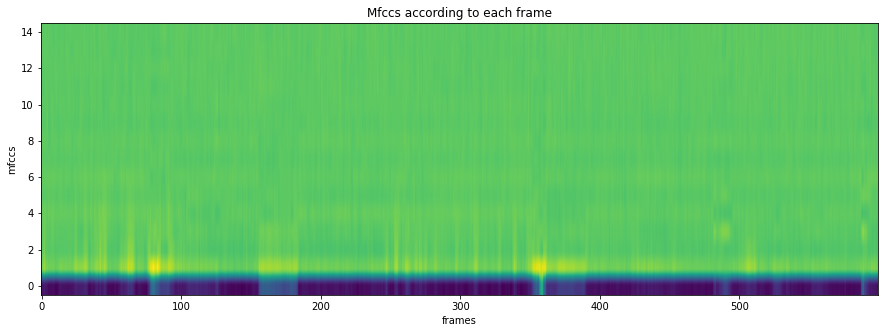

In [227]:
plt.figure(figsize=(15,5))
plt.imshow(cepstral_coefficents, aspect='auto', origin='lower');
plt.xlabel('frames')
plt.ylabel('mfccs')
plt.title('Mfccs according to each frame')
plt.show()